# Plotting PyPSA results

### Jupyter scripts need to be improved


In [1]:
# import packages

import logging
import os

import pypsa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

In [2]:
# utility function for nice plotting
max_node_size = 0.1  # maximum size of a node for plotting purposes [used in plots]


def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

### Set main directory to root folder

In [3]:
# set current folders
import sys

sys.path.append("../../")  # adds path to $ .../pypsa-africa
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-africa")  # moves path to root

This is the repository path:  c:\Users\Max\Desktop\pypsa-africa
Had to go 2 folder(s) up.


### Load all networks

In [4]:
n_2020 = os.getcwd() + "/results/networks/elec_s_54_ec_lcopt_Co2L-1H-AC-1edge-2020.nc"
n_2020 = pypsa.Network(n_2020)

n_2060 = (
    os.getcwd() + "/results/networks/elec_s_54_ec_lcopt_Co2L-1H-ACDC-1edge-2060n.nc"
)
n_2060 = pypsa.Network(n_2060)

INFO:pypsa.io:Imported network elec_s_54_ec_lcopt_Co2L-1H-AC-1edge-2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_54_ec_lcopt_Co2L-1H-ACDC-1edge-2060n.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


# 2020 Nigeria

### Network structure and load distribution

In [5]:
n = n_2020

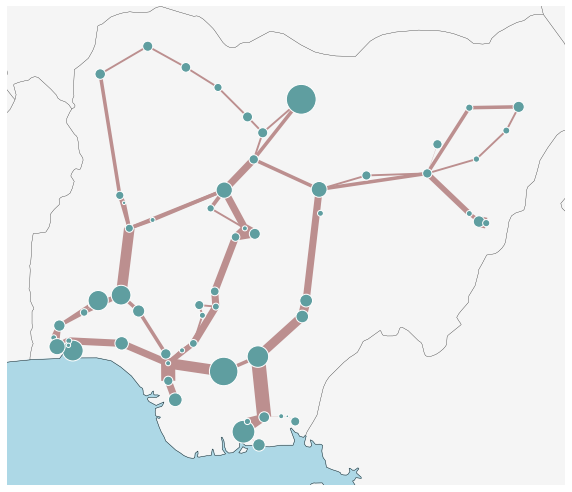

In [6]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    ),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off")

plt.savefig("nigeria-2020-loadmap.pdf", bbox_inches="tight")

### Generator distribution

In [7]:
### Options to adjust/analyse carriers in plot

# n.carriers.drop(["nuclear","biomass",])
# n.generators.groupby(by="carrier").sum()

In [8]:
###map.py von Fabian
"""
Network expansion plotting functions.
"""

__author__ = "Fabian Neumann (KIT)"
__copyright__ = "Copyright 2019-2020 Fabian Neumann (KIT), GNU GPL 3"

import pandas as pd
import numpy as np

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch


def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()

    def axes2pt():
        return np.diff(ax.transData.transform([(0, 0), (1, 1)]), axis=0)[0] * (
            300.0 / fig.dpi
        )

    ellipses = []
    if not dont_resize_actively:

        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses:
                e.width, e.height = 2.0 * radius * dist

        fig.canvas.mpl_connect("resize_event", update_width_height)
        ax.callbacks.connect("xlim_changed", update_width_height)
        ax.callbacks.connect("ylim_changed", update_width_height)

    def legend_circle_handler(
        legend, orig_handle, xdescent, ydescent, width, height, fontsize
    ):
        w, h = 2.0 * orig_handle.get_radius() * axes2pt()
        e = Ellipse(
            xy=(0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent),
            width=w,
            height=w,
        )
        ellipses.append((e, orig_handle.get_radius()))
        return e

    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}


def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0, 0), radius=(s / scale) ** 0.5, **kw) for s in sizes]


def add_legend(ax, bus_factor, branch_factor):

    handles = []
    labels = []
    for s in (1, 2.5, 5):
        handles.append(
            plt.Line2D([0], [0], color="rosybrown", linewidth=s * 1e3 / branch_factor)
        )
        labels.append(f"{s} GW")
    l1 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0, 0),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1.5,
        title="HVAC Line Capacity",
        title_fontsize=13,
        fontsize=12,
    )
    ax.add_artist(l1)

    handles = []
    labels = []
    for s in (1, 2.5, 5):
        handles.append(
            plt.Line2D(
                [0], [0], color="darkseagreen", linewidth=s * 1e3 / branch_factor
            )
        )
        labels.append(f"{s} GW")
    l2 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.0, -0.16),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1.5,
        title="HVDC Link Capacity",
        title_fontsize=13,
        fontsize=12,
    )
    ax.add_artist(l2)

    handles = []
    labels = []
    if "Load" in n.carriers.index:
        n.carriers = n.carriers.drop("Load")
    for name, carrier in n.carriers.iterrows():
        handles.append(
            plt.Line2D(
                [0], [0], color=carrier.color, marker="o", markersize=8, linewidth=0
            )
        )
        labels.append(carrier.nice_name)
    l3 = ax.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.53, -0.0),  # bbox_to_anchor=(0.72, -0.05),
        handletextpad=0.0,
        columnspacing=0.3,
        ncol=2,
        title="Technology",
        title_fontsize=13,
        fontsize=12,
        frameon=False,
    )
    ax.add_artist(l3)

    circles = [50, 25, 10]
    handles = make_legend_circles_for(circles, scale=bus_factor, facecolor="lightgray")
    labels = [f"{float(s/1e2)} GW" for s in circles]
    l4 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.82, 0.0),
        frameon=False,
        labelspacing=2.5,
        title="Generation",
        title_fontsize=13,
        fontsize=12,
        handler_map=make_handler_map_to_scale_circles_as_in(ax, True),
    )
    ax.add_artist(l4)


def plot_network(n, fn=None):

    bus_factor = 1.0e4
    branch_factor = 5e2

    fields = ["bus", "carrier", "p_nom"]
    pie_components = pd.concat(
        [
            n.generators.loc[n.generators.carrier != "load", fields],
            n.storage_units[fields],
        ]
    )
    bus_sizes = pie_components.groupby(["bus", "carrier"]).p_nom.sum() / bus_factor

    def clip(df, thres=500):
        return df.where(df > thres, other=0.0)

    line_widths = clip(n.lines.s_nom_opt - n.lines.s_nom) / branch_factor
    link_widths = clip(n.links.p_nom_opt - n.links.p_nom) / branch_factor
    line_widths_opt = n.lines.s_nom_opt / branch_factor

    fig, ax = plt.subplots(
        figsize=(11, 11), subplot_kw={"projection": ccrs.PlateCarree()}
    )

    n.plot(
        ax=ax,
        bus_sizes=bus_sizes,
        color_geomap=True,
        bus_alpha=0.7,
        line_widths=line_widths_opt,
        line_colors="#dddddd",
    )

    n.plot(
        ax=ax,
        geomap=True,
        bus_sizes=0,
        line_widths=line_widths,
        link_widths=link_widths,
    )

    add_legend(ax, bus_factor, branch_factor)

    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")

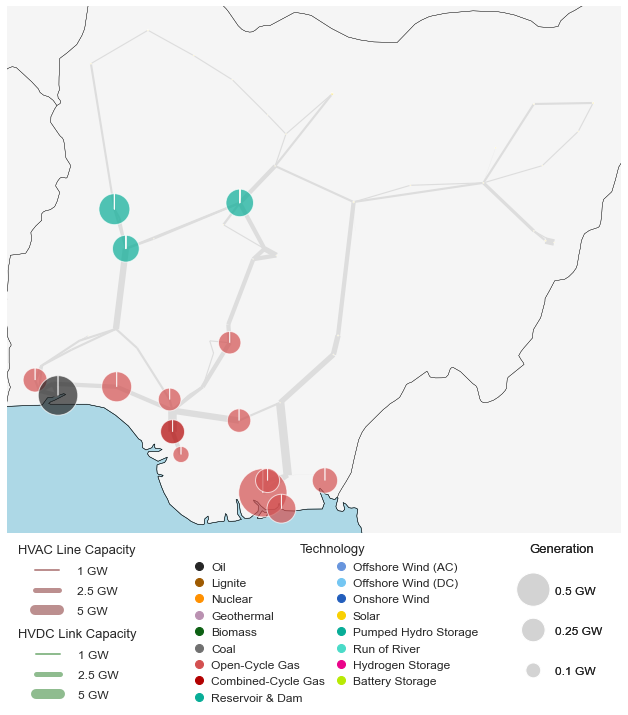

In [9]:
plot_network(n)
# plot_network(n, fn="nigeria-2020-optimization.pdf")

# 2060 Nigeria

### Network structure and load distribution

In [10]:
n = n_2060

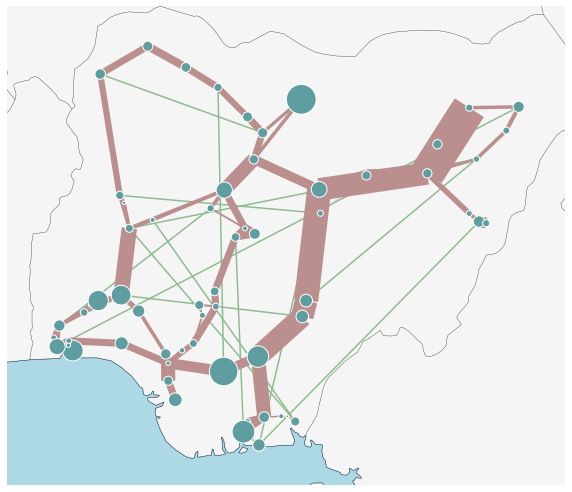

In [11]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    ),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off")

plt.savefig("nigeria-2060-loadmap.pdf", bbox_inches="tight")

### Generator distribution

In [12]:
n.carriers

,co2_emissions,color,nice_name,max_growth
Carrier,,,,
oil,0.248,#262626,Oil,inf
OCGT,0.187,#d35050,Open-Cycle Gas,inf
CCGT,0.187,#b20101,Combined-Cycle Gas,inf
nuclear,0.000,#ff9000,Nuclear,inf
geothermal,0.026,#ba91b1,Geothermal,inf
offwind-dc,0.000,#74c6f2,Offshore Wind (DC),inf
offwind-ac,0.000,#6895dd,Offshore Wind (AC),inf
onwind,0.000,#235ebc,Onshore Wind,inf
solar,0.000,#f9d002,Solar,inf


In [13]:
h2_electrolysis = {
    "co2_emissions": 0.0,
    "color": "#e34fa5",
    "nice_name": "H2 Electrolysis",
    "max_growth": np.inf,
}

h2_fuelcell = {
    "co2_emissions": 0.0,
    "color": "#ea048a",
    "nice_name": "H2 Fuel Cell",
    "max_growth": np.inf,
}

battery_inverter = {
    "co2_emissions": 0.0,
    "color": "#b8ea04",
    "nice_name": "Battery Inverter",
    "max_growth": np.inf,
}

n.carriers.loc["H2 electrolysis"] = h2_electrolysis
n.carriers.loc["H2 fuel cell"] = h2_fuelcell
n.carriers.loc["battery discharger"] = battery_inverter

In [14]:
###map.py von Fabian
"""
Network expansion plotting functions.
"""

__author__ = "Fabian Neumann (KIT)"
__copyright__ = "Copyright 2019-2020 Fabian Neumann (KIT), GNU GPL 3"

import pandas as pd
import numpy as np

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch


def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()

    def axes2pt():
        return np.diff(ax.transData.transform([(0, 0), (1, 1)]), axis=0)[0] * (
            300.0 / fig.dpi
        )

    ellipses = []
    if not dont_resize_actively:

        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses:
                e.width, e.height = 2.0 * radius * dist

        fig.canvas.mpl_connect("resize_event", update_width_height)
        ax.callbacks.connect("xlim_changed", update_width_height)
        ax.callbacks.connect("ylim_changed", update_width_height)

    def legend_circle_handler(
        legend, orig_handle, xdescent, ydescent, width, height, fontsize
    ):
        w, h = 2.0 * orig_handle.get_radius() * axes2pt()
        e = Ellipse(
            xy=(0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent),
            width=w,
            height=w,
        )
        ellipses.append((e, orig_handle.get_radius()))
        return e

    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}


def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0, 0), radius=(s / scale) ** 0.5, **kw) for s in sizes]


def add_legend(ax, bus_factor, branch_factor):

    handles = []
    labels = []
    for s in (2, 5, 10):
        handles.append(
            plt.Line2D([0], [0], color="rosybrown", linewidth=s * 1e3 / branch_factor)
        )
        labels.append(f"{s} GW")
    l1 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0, 0),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1.5,
        title="HVAC Line Capacity",
        title_fontsize=13,
        fontsize=12,
    )
    ax.add_artist(l1)

    handles = []
    labels = []
    for s in (2, 5, 10):
        handles.append(
            plt.Line2D(
                [0], [0], color="darkseagreen", linewidth=s * 1e3 / branch_factor
            )
        )
        labels.append(f"{s} GW")
    l2 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.0, -0.16),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1.5,
        title="HVDC Link Capacity",
        title_fontsize=13,
        fontsize=12,
    )
    ax.add_artist(l2)

    handles = []
    labels = []
    if "Load" in n.carriers.index:
        n.carriers = n.carriers.drop("Load")
    for name, carrier in n.carriers.iterrows():
        handles.append(
            plt.Line2D(
                [0], [0], color=carrier.color, marker="o", markersize=8, linewidth=0
            )
        )
        labels.append(carrier.nice_name)
    l3 = ax.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.53, -0.0),  # bbox_to_anchor=(0.72, -0.05),
        handletextpad=0.0,
        columnspacing=0.3,
        ncol=2,
        title="Technology",
        title_fontsize=13,
        fontsize=12,
        frameon=False,
    )
    ax.add_artist(l3)

    circles = [500, 250, 100]
    handles = make_legend_circles_for(circles, scale=bus_factor, facecolor="lightgray")
    labels = [f"{float(s/1e2)} GW" for s in circles]
    l4 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.82, 0.0),
        frameon=False,
        labelspacing=2.5,
        title="Generation",
        title_fontsize=13,
        fontsize=12,
        handler_map=make_handler_map_to_scale_circles_as_in(ax, True),
    )
    ax.add_artist(l4)


def plot_network(n, fn=None):

    bus_factor = 8.0e4
    branch_factor = 5e2

    fields = ["bus", "carrier", "p_nom_opt"]
    fields_charger = ["bus0", "carrier", "p_nom_opt"]
    fields_discharger = ["bus1", "carrier", "p_nom_opt"]
    pie_components = pd.concat(
        [
            # n.generators.loc[n.generators.carrier != "load", fields],
            n.generators.query("carrier in ['solar', 'onwind']").loc[:, fields],
            n.storage_units.query("carrier in ['hydro']").loc[:, fields],
            n.links.loc[
                n.links.carrier.str.contains("H2 electrolysis"), fields_charger
            ].rename(columns={"bus0": "bus"}),
            n.links.loc[
                n.links.carrier.str.contains("battery discharger|H2 fuel cell"),
                fields_discharger,
            ].rename(columns={"bus1": "bus"}),
        ]
    )
    bus_sizes = pie_components.groupby(["bus", "carrier"]).p_nom_opt.sum() / bus_factor

    def clip(df, thres=500):
        return df.where(df > thres, other=0.0)

    line_widths = clip(n.lines.s_nom_opt - n.lines.s_nom) / branch_factor
    link_widths = clip(n.links.p_nom_opt - n.links.p_nom) / branch_factor
    line_widths_opt = n.lines.s_nom_opt / branch_factor

    fig, ax = plt.subplots(
        figsize=(11, 11), subplot_kw={"projection": ccrs.PlateCarree()}
    )

    n.plot(
        ax=ax,
        bus_sizes=bus_sizes,
        color_geomap=True,
        bus_alpha=0.7,
        line_widths=line_widths_opt,
        line_colors="#dddddd",
        link_widths=0,
    )

    n.plot(
        ax=ax,
        geomap=True,
        bus_sizes=0,
        line_widths=line_widths,
        link_widths=0,
    )

    add_legend(ax, bus_factor, branch_factor)

    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")

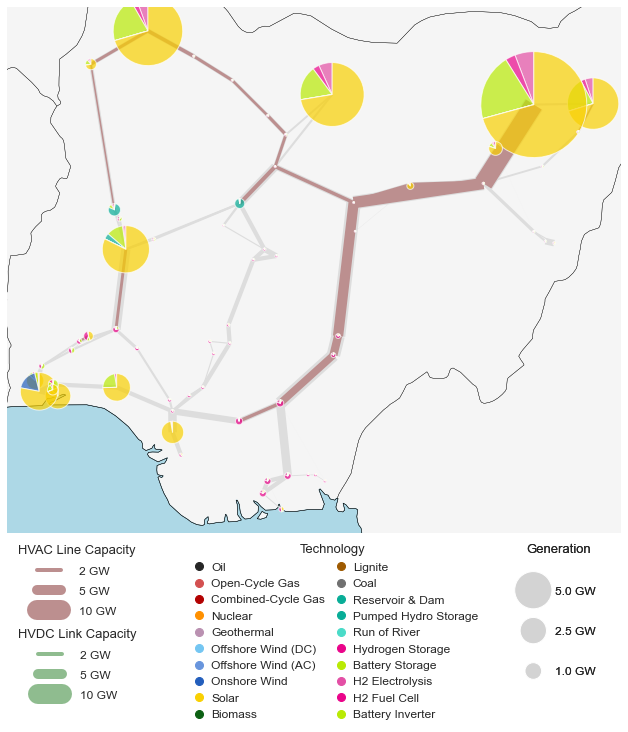

In [15]:
plot_network(n)
# plot_network(n, fn="nigeria-2060-optimization.pdf")